# Pilot data check - TODO

- frame rate/subject
- number of grasps/subject
- number of eye samples/object
- number of eye samples/grasped object
- number of eye samples/grasped object/sorting type --> shouldn't be different
- number of samples with NaN
- validation error across trials/subject
- azimuth and elevation angles/subject (histograms)
- Amplitude of head movements based on velocity
- Saccade amplitude based on velocity

# Quick notes
Subjects 1001, 1002, 1003, 1004, 1005, 1007 --> grasped object not recorded in handData

In [1]:
# %pip install pprint
# fill this value to sun script for that particular subject
subjectID = '2001'

In [2]:
import ProtobufTypes_pb2 
import pandas as pd
import sys
from google.protobuf.json_format import MessageToDict
import collections
import numpy as np
import glob
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle
import pprint
from IPython.display import display
PLOT_DIR = './PLOTS/data_quality/'
os.makedirs(os.path.dirname(PLOT_DIR), exist_ok=True)
sns.set(context = "talk", style="white", palette="dark", font_scale=1, rc={'figure.figsize':(11.7,8.27)})
COLORS = {'g': '#CAE6CB', 'r': '#E6CACA', 'b': '#C9D4F5'}

In [3]:
# pickle the data
def pickleData(filepath,filename, data):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(str(filepath+filename),'wb') as fh:
        pickle.dump(data,fh)

# read from pickled data
def read_dataFrameFromFile(filename):
    with open(filename, 'rb') as fh:
        dataframe = pickle.load(fh)
    return dataframe

In [4]:
protobuf_obj = ProtobufTypes_pb2.EyetrackingDataSet()
with open('subject{}.etd'.format(subjectID), "rb") as f:
    protobuf_obj.ParseFromString(f.read())
dict_obj = MessageToDict(protobuf_obj)

In [5]:
samples_df = pd.DataFrame()
for trial in dict_obj['trials']:
    tmpdf = pd.io.json.json_normalize(data=trial['samples'])
    tmpdf['trialID'] = trial['metaData']['trialID'] if 'trialID' in trial['metaData'] else np.NaN  
    samples_df = pd.concat([samples_df, tmpdf], ignore_index=True, sort=False)

samples_df['subID'] = subjectID
# pickleData('./Data/subject{}/'.format(subjectID),'trialData',samples_df)

In [7]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181636 entries, 0 to 181635
Data columns (total 70 columns):
timestamp                           181636 non-null float64
leftEye.position.x                  181196 non-null float64
leftEye.position.y                  181196 non-null float64
leftEye.position.z                  181196 non-null float64
leftEye.direction.x                 181191 non-null float64
leftEye.direction.y                 181192 non-null float64
leftEye.direction.z                 181636 non-null float64
leftEye.raycastHitObject            181143 non-null object
leftEye.raycastHitLocation.x        181143 non-null float64
leftEye.raycastHitLocation.y        177480 non-null float64
leftEye.raycastHitLocation.z        181143 non-null float64
leftEye.eyeOpenness                 181620 non-null float64
rightEye.position.x                 180220 non-null float64
rightEye.position.y                 180220 non-null float64
rightEye.position.z                 180220 non-nul

In [7]:
samples_df.shape

(113247, 70)

In [14]:
display(samples_df.isna().sum().to_frame())
samples_df.trialID.unique()

,0
timestamp,0
leftEye.position.x,440
leftEye.position.y,440
leftEye.position.z,440
leftEye.direction.x,445
leftEye.direction.y,444
leftEye.direction.z,0
leftEye.raycastHitObject,493
leftEye.raycastHitLocation.x,493
leftEye.raycastHitLocation.y,4156


array([nan,  2.,  8., 10.,  1.,  7.,  6.,  9.,  3.,  5.,  4., 11.])

In [19]:
samples_df.dropna(subset=['trialID'], inplace=True)

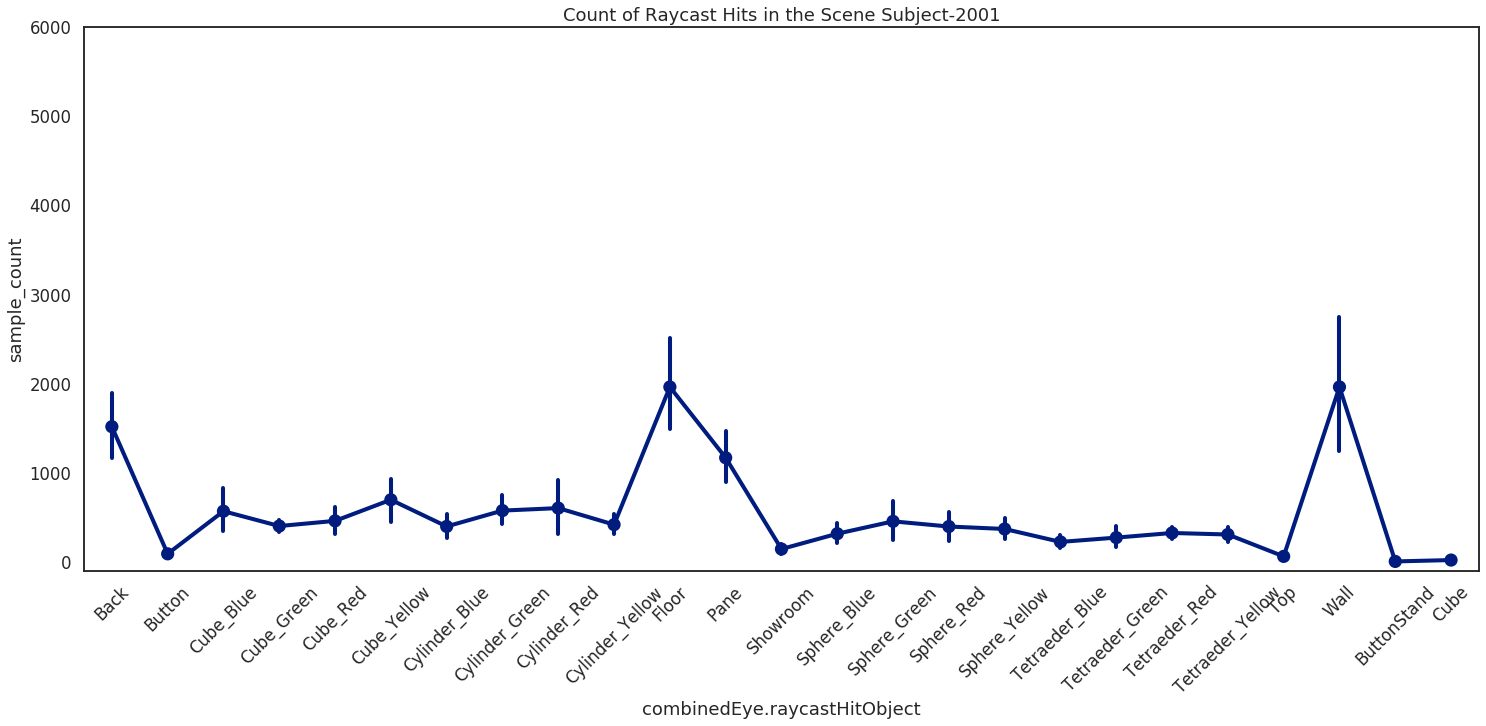

In [9]:
tmpdf = (
    samples_df
    .groupby(['trialID','combinedEye.raycastHitObject'])
    .agg({'trialID':'count'})
    .rename(columns={'trialID':'sample_count',})
    .reset_index()
)
fig = plt.figure(figsize=(25,10))
ax = sns.pointplot(data=tmpdf, x='combinedEye.raycastHitObject', y='sample_count', ci=80)
ax.set_ylim(-100,6000)
plt.xticks(rotation=45)
plt.title('Count of Raycast Hits in the Scene Subject-{}'.format(subjectID))
plt.savefig(PLOT_DIR+'/hits_all_objects_subject{}.png'.format(subjectID), quality=90)

In [10]:
def replace_objs(s):
    valid_objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 'Cylinder_Blue', 'Cylinder_Green',
                  'Cylinder_Red','Cylinder_Yellow', 'Sphere_Blue', 'Sphere_Green', 'Sphere_Red',
                  'Sphere_Yellow', 'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']
    if s in valid_objs:
        return s
    else:
        return 'Other'

samples_df['combinedEye.raycastHitObject'] = samples_df['combinedEye.raycastHitObject'].apply(replace_objs)

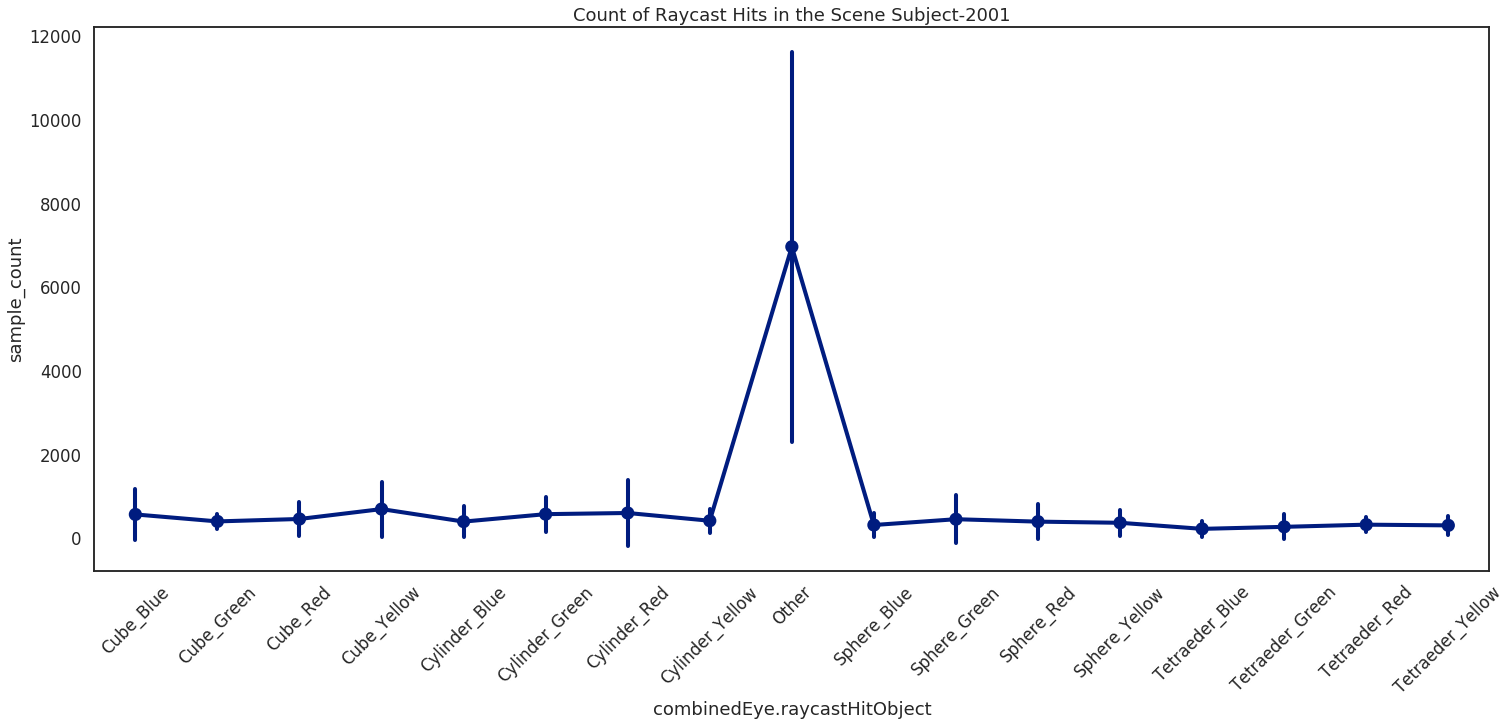

In [11]:
tmpdf = (
    samples_df
    .groupby(['trialID','combinedEye.raycastHitObject'])
    .agg({'trialID':'count'})
    .rename(columns={'trialID':'sample_count',})
    .reset_index()
)
fig = plt.figure(figsize=(25,10))
ax = sns.pointplot(data=tmpdf, x='combinedEye.raycastHitObject', y='sample_count', ci='sd')
plt.xticks(rotation=45)
plt.title('Count of Raycast Hits in the Scene Subject-{}'.format(subjectID))
plt.savefig(PLOT_DIR+'/hits_shelf_objects_subject{}.png'.format(subjectID), quality=90)

In [21]:
tmpdf = (
    samples_df
    .groupby(['trialID'])['handData.graspedObject']
    .nunique()
#     .agg({'handData.graspedObject':'count'})
#     .rename(columns={'trialID':'sample_count',})
#     .reset_index('Nr of Grasps')
)
display(tmpdf)
fig = plt.figure(figsize=(25,10))
ax = sns.pointplot(data=tmpdf, x='trialID', y='sample_count', ci='sd')
plt.xticks(rotation=45)
plt.title('Count of Raycast Hits in the Scene Subject-{}'.format(subjectID))
plt.savefig(PLOT_DIR+'/hits_shelf_objects_subject{}.png'.format(subjectID), quality=90)

trialID
1.0     11
2.0     15
3.0      9
4.0     13
5.0     11
6.0     12
7.0      9
8.0     16
9.0      9
10.0    15
11.0    11
Name: handData.graspedObject, dtype: int64

ValueError: Could not interpret input 'trialID'

<Figure size 1800x720 with 0 Axes>

In [ ]:
raise

In [22]:
tmpdf = (
    trials_df
    .samples.apply(lambda d: pd.io.json.json_normalize(d[:2]))
    # .to_frame('samples')
)

tmpdf.apply(lambda s: display(s))

NameError: name 'trials_df' is not defined

In [23]:
times = frames.reset_index().groupby(['subjectID','blockID'])['timeStamp']\
                                    .apply(lambda x: 1/np.mean((x - x.shift())/np.timedelta64(1,'s')))\
                                    .rename('Frame Rate')\
                                    .reset_index()
# times = times.groupby(level = 0).agg({'Frame Rate':['mean','std']}).reset_index()
sns.set(context = "talk", style="white", palette="Accent", font_scale=1, rc={'figure.figsize':(14,8.27)})
sns.barplot(data=times, x='subjectID', y='Frame Rate', color=COLORS['g'],errwidth=2, capsize=0,\
                                                                                saturation=0.5,ci='sd')

plt.ylabel('Frame rate (Hz)')
plt.title('Frame Rate Over Subjects')
plt.savefig(PLOT_DIR+'/framerate_persubject.png', quality=90, dpi=1000)

NameError: name 'frames' is not defined

In [ ]:
#change angles to be within 180 degrees
sel_columns = ['combinedEyeAngleOffset.x', 'combinedEyeAngleOffset.y','combinedEyeAngleOffset.z',
               'leftEyeAngleOffset.x', 'leftEyeAngleOffset.y','leftEyeAngleOffset.z',
               'rightEyeAngleOffset.x', 'rightEyeAngleOffset.y','rightEyeAngleOffset.z']

for col in sel_columns:
    val_df.loc[val_df[col]>360, col] = val_df[col] - 360
    val_df.loc[val_df[col]>180, col] = 360 - val_df[col]

# Scratch

In [ ]:
# dict_obj = MessageToDict(protobuf_obj)
dict_obj['trials'][2]['samples'][1]['handData']

In [ ]:
dict_obj['trials'][1]['samples']

In [ ]:
eye_df.trialID.value_counts()